# Q-Learning Path Planning

> In this notebook, I used Q-Learning to tackle the path planning problem.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm.auto import tqdm

> The basic idea of using Q-learning for path finding involves teaching an agent to navigate from a start point to a destination in an environment by learning from its experiences. </br>
> To guide the agent, rewards are given for desirable outcomes and penalties for undesirable ones.

### Q-Learning Method for Task 1


##### Code

In [18]:
# Define the grid environment
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start = (4, 0)  
        self.goal = (0, 4)   
        self.obstacles = [(1, 2), (2, 3), (3, 4), (3, 1)]  
        self.state = self.start
        self.end_states = [self.goal]

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        reward = -1 # small penalty for each step so that the agent tries to reach the goal in as few steps as possible
        if self.state in self.end_states:
            return self.state, reward, True

        # Calculate the next state given the action
        next_state = list(self.state)
        if action == 0:  # up
            if next_state[0] > 0:
                next_state[0] -= 1
        elif action == 1:  # down
            if next_state[0] < self.size - 1:
                next_state[0] += 1
        elif action == 2:  # left
            if next_state[1] > 0:
                next_state[1] -= 1
        elif action == 3:  # right
            if next_state[1] < self.size - 1:
                next_state[1] += 1

        # Check for obstacles
        if tuple(next_state) in self.obstacles:
            next_state = self.state

        # Check if the goal is reached
        if tuple(next_state) == self.goal:
            reward = 100

        # update state
        self.state = tuple(next_state)
        return self.state, reward, self.state in self.end_states

    def get_actions(self):
        return [0, 1, 2, 3]


In [19]:
# Initialize the agent's Q-table
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.6, epsilon=0.1):
        self.q_table = np.zeros((env.size, env.size, len(env.get_actions())))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env

    def choose_action(self, state): # stochastically
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.env.get_actions())  # Explore action space
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # Exploit learned values

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state[0], state[1], action]
        next_max = np.max(self.q_table[next_state[0], next_state[1]])

        # Update the Q-value for the current state and action
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state[0], state[1], action] = new_value


    def train(self, episodes=1000):
        for _ in tqdm(range(episodes)):
            state = self.env.reset()
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
            
        



In [29]:
def visualize_grid(agent, env):
    grid = np.zeros((env.size, env.size))
    for obstacle in env.obstacles:
        grid[obstacle] = 1  
    if hasattr(env, 'waypoints'): # This line for task 2
        for waypoint in env.waypoints:
            grid[waypoint] = 2   
    grid[env.start] = 3  
    grid[env.goal] = 4  

    # Retrieve the best path from the Q-table
    state = env.start
    path = [state]
    while state not in env.end_states:
        action = np.argmax(agent.q_table[state[0], state[1]])
        next_state = (state[0], state[1])
        if action == 0 and state[0] > 0:  # up
            next_state = (state[0] - 1, state[1])
        elif action == 1 and state[0] < env.size - 1:  # down
            next_state = (state[0] + 1, state[1])
        elif action == 2 and state[1] > 0:  # left
            next_state = (state[0], state[1] - 1)
        elif action == 3 and state[1] < env.size - 1:  # right
            next_state = (state[0], state[1] + 1)

        if next_state in env.obstacles or next_state == state:
            # Break if the next state is an obstacle or the same as the current state (no movement)
            break

        path.append(next_state)
        state = next_state
        if state in env.end_states:
            break
    
    if hasattr(env, 'elevation'):
        grid = env.elevation
    # Visualize the grid with the path
    fig, ax = plt.subplots(figsize=(5, 5))
    cmap = plt.cm.viridis
    norm = plt.Normalize(0, 4)
    ax.imshow(grid, cmap=cmap, norm=norm)

    # gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='black', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.size, 1))
    ax.set_yticks(np.arange(-.5, env.size, 1))

    # Draw start and finish points
    ax.text(env.start[1], env.start[0], 'S', va='center', ha='center', color='black', fontsize=16)
    ax.text(env.goal[1], env.goal[0], 'F', va='center', ha='center', color='black', fontsize=16)
    for obstacle in env.obstacles: 
        ax.text(obstacle[1], obstacle[0], 'O', va='center', ha='center', color='black', fontsize=16)

    if hasattr(env, 'waypoints'):
        # Draw waypoints
        for waypoint in env.waypoints:
            ax.text(waypoint[1], waypoint[0], 'W', va='center', ha='center', color='black', fontsize=16)
    

    # Draw the arrows representing the path
    num_steps = len(path)
    colors = plt.cm.Wistia(np.linspace(0, 1, num_steps))
    count = 0
    for start, end in zip(path[:-1], path[1:]):
        count += 1
        ax.annotate("", xy=(end[1], end[0]), xycoords='data',
                    xytext=(start[1], start[0]), textcoords='data',
                    arrowprops=dict(arrowstyle="->", color=colors[count], lw=1.5))

    plt.show()


##### Result

  0%|          | 0/100 [00:00<?, ?it/s]

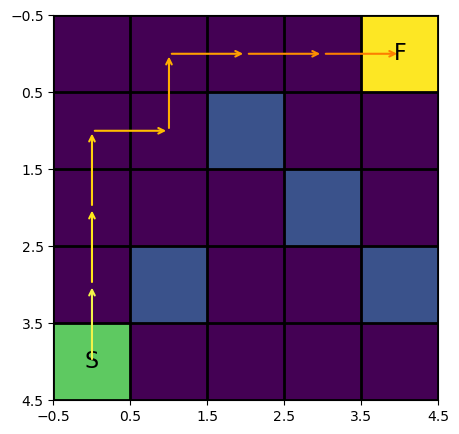

In [21]:

environment = GridWorld()
q_learning_agent = QLearningAgent(environment)

q_learning_agent.train(episodes=100)

visualize_grid(q_learning_agent, environment)


### Q-Learning Method for Task 2

> The idea for this task is to set a middle reward when reaching each waypoint and to penalize attempts when arriving at the end point without having visited all waypoints.

##### Code

In [22]:
class GridWorldWithWaypoints:
    def __init__(self, size=5):
        self.size = size
        self.start = (4, 0)  
        self.goal = (0, 4)   
        self.obstacles = [(1, 2), (2, 3), (3, 4), (3, 1)]  
        self.waypoints = [(2, 2), (1, 4)]  
        self.state = self.start
        self.end_states = [self.goal]
        self.waypoint_order = []  # Keep track of visited waypoints

    def reset(self):
        self.state = self.start
        self.waypoint_order = []  # Reset the visited waypoints
        return self.state

    def step(self, action):
        if self.state in self.end_states:
            return self.state, 0, True  # No reward for staying in the goal

        # Determine next state
        row, col = self.state
        if action == 0 and row > 0:  # up
            row -= 1
        elif action == 1 and row < self.size - 1:  # down
            row += 1
        elif action == 2 and col > 0:  # left
            col -= 1
        elif action == 3 and col < self.size - 1:  # right
            col += 1
        next_state = (row, col)

        # Check for obstacles
        if next_state in self.obstacles:
            next_state = self.state  # No movement

        # Update the state
        self.state = next_state

        # Check for waypoints and goal state
        reward, done = self.evaluate_rewards_and_done()
        return self.state, reward, done

    def evaluate_rewards_and_done(self):
        reward = -1  # Default cost
        done = False

        # Check if a waypoint is reached and it hasn't been visited yet
        if self.state in self.waypoints and self.state not in self.waypoint_order:
            self.waypoint_order.append(self.state)
            reward = 10  # Reward for visiting a waypoint

        # Check if the goal is reached
        if self.state == self.goal:
            if set(self.waypoint_order) == set(self.waypoints):
                reward = 100  # Big reward for visiting all waypoints and then reaching the goal
                done = True  # End the episode
            else:
                reward = -100  # Penalty for reaching the goal without visiting all waypoints
                done = True  # Still end the episode, but with a penalty

        return reward, done



    def get_actions(self):
        return [0, 1, 2, 3]


##### Result

  0%|          | 0/100 [00:00<?, ?it/s]

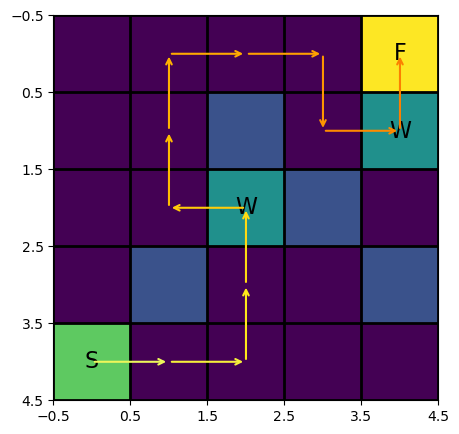

In [23]:
env = GridWorldWithWaypoints()
agent = QLearningAgent(env)

agent.train(episodes=100)

visualize_grid(agent, env)

### Q-Learning Method for Task 3

> This task is super easy, we just raise the step penalties with the elevation gain of the cell.

##### Code

In [27]:
class GridWorldWithWaypointsElevation:
    def __init__(self, size=5):
        self.size = size
        self.start = (4, 0)  
        self.goal = (0, 4)   
        self.obstacles = [(1, 2), (2, 3), (3, 4), (3, 1)]  
        self.waypoints = [(2, 2), (1, 4)]  
        self.state = self.start
        self.end_states = [self.goal]
        self.waypoint_order = []  # Keep track of visited waypoints
        self.elevation = [
            [1, 1, 2, 2, 1],  
            [1, 2, 2, 3, 2],
            [2, 2, 3, 3, 2],
            [1, 2, 3, 3, 3],
            [1, 1, 2, 2, 2]
        ]

    def reset(self):
        self.state = self.start
        self.waypoint_order = []  # Reset the visited waypoints
        return self.state

    def step(self, action):
        if self.state in self.end_states:
            return self.state, 0, True  # No reward for staying in the goal

        # Determine next state
        row, col = self.state
        if action == 0 and row > 0:  # up
            row -= 1
        elif action == 1 and row < self.size - 1:  # down
            row += 1
        elif action == 2 and col > 0:  # left
            col -= 1
        elif action == 3 and col < self.size - 1:  # right
            col += 1
        next_state = (row, col)

        # Check for obstacles
        if next_state in self.obstacles:
            next_state = self.state  # No movement

        # Update the state
        prev_state = self.state
        self.state = next_state

        # Check for waypoints and goal state
        reward, done = self.evaluate_rewards_and_done(prev_state, self.state)
        return self.state, reward, done

    def evaluate_rewards_and_done(self, previous, current):
        reward = -1 - (self.elevation[current] - self.elevation[previous] if self.elevation[current] > self.elevation[previous] else 0)  # Default cost
        done = False

        # Check if a waypoint is reached and it hasn't been visited yet
        if self.state in self.waypoints and self.state not in self.waypoint_order:
            self.waypoint_order.append(self.state)
            reward = 20  # Reward for visiting a waypoint

        # Check if the goal is reached
        if self.state == self.goal:
            if set(self.waypoint_order) == set(self.waypoints):
                reward = 100  # Big reward for visiting all waypoints and then reaching the goal
                done = True  # End the episode
            else:
                reward = -100  # Penalty for reaching the goal without visiting all waypoints
                done = True  # Still end the episode, but with a penalty

        return reward, done



    def get_actions(self):
        return [0, 1, 2, 3]


  0%|          | 0/1000 [00:00<?, ?it/s]

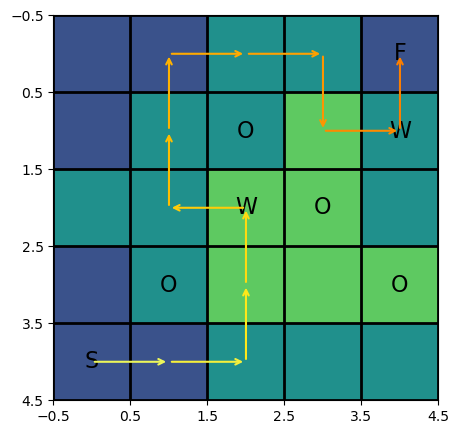

In [30]:
e_env = GridWorldWithWaypointsElevation()
e_agent = QLearningAgent(env)

e_agent.train(episodes=1000)

visualize_grid(e_agent, e_env)

##### Result